### Project Overview

This project continues from HW4 and focuses on improving the performance of the Net-5 model for ZIP recongition.  
The following code includes data loading, preprocessing, model adjustments, training, and evaluation steps.

In [1]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from PIL import Image # handle image loading and processing

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# Load monochrome BMP file and convert it into int numpy array
img = np.array(Image.open('zip_numerals.bmp')).astype(int)

In [3]:
# Create empty arrays to stroe the cropped images (X) and their corresponding labels (y)
# X: 480 grayscale images of size 16x16, and 1 channel dimension because the images are grayscale
# y: labels for each image, the digit 0-9
X = np.zeros(shape=(480, 16, 16, 1))
y = np.zeros(shape=(480, 1))
example_idx = 0 # Index to keep track of where to store the next example

for i in range(10):
    for j in range(12):
        # Crop 13x16 patch from the data image
        # One pixel is between numerals, so multiply on 17 and 14
        si, fi = i*17, i*17+16
        sj, fj = j*14, j*14+13
        patch = 1 - img[si:fi, sj:fj] # Apply 1 - img to invert colors: make the numeral white and background black
        
        # Shift the patch slightly to the right to create 4 slightly different versions
        for k in range(4):
            X[example_idx, 0:16, k:k+13, 0] = patch
            y[example_idx, 0] = i
            example_idx += 1

In [4]:
# Stratified train-test split to maintain the same class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=320, random_state=10, stratify=y)

In [5]:
ohe = OneHotEncoder(categories='auto').fit(y)

# Convert the class labels into one-hot encoded vectors
# One-hot encoding produces a sparese matrix to save memory (only nonzero entries are stored)
# So use toarray() to convert it into a dense numpy array
Y_train = ohe.transform(y_train).toarray()
Y_test = ohe.transform(y_test).toarray()

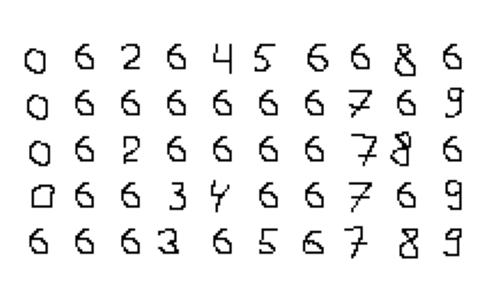

In [6]:
# Show some training examples
w = 20
result = np.zeros(shape=(4+w*5, 4+w*10))

for d in range(10):
    # Find all indixes in y_train where the label matches the current digit
    d_idx = np.argwhere(y_train==d).flatten()
    # Randomly select 5 unique samples for this digit (without replacement)
    d_idx = np.random.choice(d_idx, 5, replace=False)
    for i, idx in enumerate(d_idx):
        result[i*w+4:i*w+20, d*w+4:d*w+20] = -X_train[idx].reshape((16, 16))

fig, ax = plt.subplots(figsize=(5.5, 3.3), dpi=110)
ax.imshow(result, cmap="gray")
ax.set_aspect('equal', 'datalim')
ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Convert data to torch tensors
# Change the shape from [batch_size, height, width, channels] to [batch_size, channels, height, width] for pytorch
# Here, since the entire dataset is small (320 samples for training, 160 samples for testing), all sampels are processed together without splitting into mini-batches
# .to(device): Move the data to the selected device for computation
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float32).to(device)

In [9]:
# Define the training procedure
def train_model(model, criterion, optimizer, n_epochs, X_train, Y_train, X_test, Y_test):
    accuracy_test = []
    
    for epoch in range(n_epochs):
        
        model.train() # Set the model to training mode
        for i in range(X_train.shape[0]): # 320
            optimizer.zero_grad() # Clear previous gradients
            output = model(X_train[i:i+1]) # Forward pass on one training sample
            loss = criterion(output, Y_train[i:i+1]) # Compute loss
            loss.backward() # Backpropagate the loss
            optimizer.step() # Update model parameters

        model.eval() # Set the model to evaluation mode
        with torch.no_grad(): # Disable gradient computation for evaluation
            y_test_hat = torch.argmax(model(X_test), dim=1) # Take the predicted class with the highest score for each sample (along the class dimension)
            y_test_labels = torch.argmax(Y_test, dim=1)
            accuracy = accuracy_score(y_test_labels, y_test_hat)
            accuracy_test.append(accuracy)
    
    return accuracy_test

**Net-5**

The main steps are:  
1) Leverage a convolution layer to exploit the spatial structure of images.
2) Use the tanh activation function.
    * To compress outputs into the rang [-1, 1] and prevent values from exploding.
    * To introduce non-linearity so the model can learn complex patterns beyond straight lines.
3) Leverage another convolution layer to extract higher-level spatial features.
4) Use the tanh activation function.
5) Flatten the feature maps into a 1D vector.
6) Apply a linear transformation that maps flattened features into 10 classes.
7) Use the softmax activation function to convert the scores into probabilities

In [10]:
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(2, 4, kernel_size=5, stride=1, padding=0)
        self.fc = nn.Linear(4 * 4 * 4, 10)
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = x.reshape(-1, 4 * 4 * 4)
        x = torch.softmax(self.fc(x), dim=1)
        return x

**Comparison of Net-5, Net-5v2, and Net-5v3 Architectures**
| Aspect | Net5 | Net5v2 | Netv3 |
| :-- | :-- | :-- | :-- |
| Number of convolution layers | 2 | 2 | 2 |
| Number of kernels | 2, 4 | 4, 8 | 4, 8 |
| Kernel size | (3x3), (5x5) | (3x3), (3x3) | (3x3), (3x3) |
| Stride | 2, 1 | 1, 2 | 1, 2 |
| Padding | 1, 0 | 1, 1 | 1, 1 | 
| Activation function | Tanh | ReLU | ReLU |
| Dropout | None | None | Dropout(0.5) before FC |  
| Fully connected layers | 64 -> 10 | 512 -> 10 | 512 -> 10 |
| Softmax inside model | Yes (after FC) | No (output raw logits) | No (output raw logits) |

In [11]:
class Net5v2(nn.Module):
    def __init__(self):
        super(Net5v2, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(8 * 8 * 8, 10)
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [12]:
class Net5v3(nn.Module):
    def __init__(self):
        super(Net5v3, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(8 * 8 * 8, 10)
        self.dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

Net-5                              97.5%
Net-5v2: Net-5 improved            98.1%
Net-5v3: Net-5v2 with Dropout       99.4%


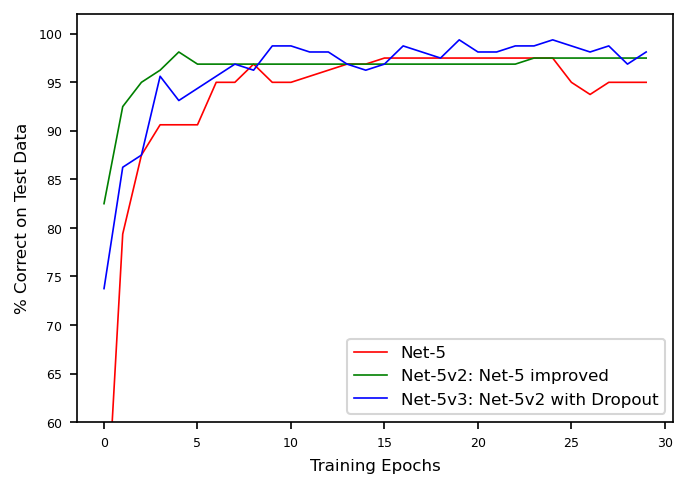

In [13]:
n_epochs = 30
learning_rate = 4e-3

model = Net5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
net5_accuracy = train_model(model, criterion, optimizer, n_epochs, X_train, Y_train, X_test, Y_test)

model2 = Net5v2().to(device)
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
net5v2_accuracy = train_model(model2, criterion, optimizer, n_epochs, X_train, Y_train, X_test, Y_test)

model3 = Net5v3().to(device)
optimizer = optim.Adam(model3.parameters(), lr=learning_rate)
net5v3_accuracy = train_model(model3, criterion, optimizer, n_epochs, X_train, Y_train, X_test, Y_test)

architectures = [
    "Net-5",
    "Net-5v2: Net-5 improved",
    "Net-5v3: Net-5v2 with Dropout"
]
test_scores = [net5_accuracy, net5v2_accuracy, net5v3_accuracy]
best_scores = [max(score) for score in test_scores]

for n, b in zip(architectures, best_scores):
    print(f'{n:<28} {100*b:>10.1f}%')
    
fig, ax = plt.subplots(figsize=(5.13, 3.53), dpi=150)
x_vals = range(n_epochs)
lines = zip(test_scores, ['red', 'green', 'blue'], architectures)
for scores, color, arc in lines:
    ax.plot(x_vals, [100*s for s in scores], linewidth=0.8, color=color, label=arc)
ax.set_xlabel('Training Epochs', fontsize=8)
ax.set_ylabel('% Correct on Test Data', fontsize=8)
ax.set_ylim(60, 102)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(6)
ax.legend(loc='lower right', prop={'size': 8})
plt.show()
